In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def get_sp500_financials():
    """Returns a list of financial sector companies in S&P 500"""
    # Sample 15 financial companies from S&P500
    financial_tickers = [
        'JPM', 'BAC', 'WFC', 'GS', 'MS',
        'BLK', 'C', 'SCHW', 'AXP', 'PNC',
        'TFC', 'USB', 'BK', 'STT', 'COF'
    ]
    return financial_tickers

def get_stock_data(tickers, start_date, end_date):
    """Fetch daily stock prices for given tickers"""
    data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.download(ticker, start=start_date, end=end_date)
        data[ticker] = stock['Adj Close']
    return data

def calculate_correlation_matrix(data):
    """Calculate correlation matrix for stock returns"""
    returns = data.pct_change()
    correlation_matrix = returns.corr()
    return correlation_matrix

def find_lowest_correlation_pair(correlation_matrix):
    """Find the pair of stocks with lowest correlation"""
    # Get the lower triangle of the correlation matrix
    lower_triangle = np.tril(correlation_matrix, k=-1)
    # Find the minimum correlation
    min_corr = np.min(lower_triangle[lower_triangle != 0])
    # Find the stocks with minimum correlation
    min_corr_idx = np.where(correlation_matrix == min_corr)
    stock1, stock2 = correlation_matrix.index[min_corr_idx[0][0]], correlation_matrix.index[min_corr_idx[1][0]]
    return stock1, stock2

def calculate_technical_indicators(data):

    """Calculate technical indicators for a stock"""
    # 1. Simple Moving Average (SMA) - 20 days & 5 days
    data['SMA_20'] = data['Adj Close'].rolling(window=20).mean()
    data['SMA_5'] = data['Adj Close'].rolling(window=5).mean()

    # 2. Relative Strength Index (RSI) - 14 days
    delta = data['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    # 3. MACD
    exp1 = data['Adj Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Adj Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = exp1 - exp2
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # 4. Bollinger Bands
    data['BB_middle'] = data['Adj Close'].rolling(window=20).mean()
    print(data["BB_middle"])
    print(data["Adj Close"])
    data.columns = data.columns.droplevel(level=1)
    data['BB_upper'] = data['BB_middle'] + 2*data['Adj Close'].rolling(window=20).std()
    data['BB_lower'] = data['BB_middle'] - 2*data['Adj Close'].rolling(window=20).std()

    # 5. Volume Rate of Change
    data['Volume_ROC'] = data['Volume'].pct_change(periods=5) * 100

    return data

def get_fundamental_indicators(ticker, start_date, end_date):
    """Get fundamental indicators for a stock"""
    stock = yf.Ticker(ticker)
    def secure_get(s):
        answer = tickers.info.get(s, np.nan)
        return answer

    tickers = yf.Ticker(ticker)
    row = {"ticker": ticker}
    ROE = secure_get("returnOnEquity")
    ROA = secure_get("returnOnAssets")
    PBR = secure_get("priceToBook")
    BPS = secure_get("bookValue") / secure_get("sharesOutstanding")
    PCR = (secure_get("previousClose") * secure_get("sharesOutstanding")) / secure_get("operatingCashflow")
    PSR = (secure_get("previousClose") * secure_get("sharesOutstanding")) / secure_get("totalRevenue")
    market_cap = secure_get("marketCap")
    five_year_dividend_rate = secure_get("fiveYearAvgDividendYield")
    bid_ask_spread = secure_get("bid") - secure_get("ask")
    profit_margins = secure_get("profitMargins")
    enterprise_ebitda = secure_get("enterpriseToEbitda")
    current_ratio = secure_get("currentRatio")
    debt_equity = secure_get("debtToEquity")
    earning_growth =secure_get("earningsGrowth")

    row["ROE"] = ROE
    row["ROA"] = ROA
    row["PBR"] = PBR
    row["BPS"] = BPS
    row["PCR"] = PCR
    row["PSR"] = PSR
    row["market_cap"] = market_cap
    row["five_year_dividend_rate"] = five_year_dividend_rate
    row["bid_ask_spread"] = bid_ask_spread
    row["profit_margins"] = profit_margins
    row["ebitda"] = enterprise_ebitda
    row["current_ratio"] = current_ratio
    row["debt_equity"] = debt_equity
    row["earning_growth"] = earning_growth
    return row


def get_market_data(start_date, end_date):
    """Get S&P 500 and VIX data for reference"""
    sp500 = yf.download('^GSPC', start=start_date, end=end_date)
    vix = yf.download('^VIX', start=start_date, end=end_date)
    return sp500['Adj Close'], vix['Adj Close']

# Main analysis function
def run_analysis():
    start_date = '2019-07-01'
    end_date = '2022-12-31'

    # Step 1 & 2: Get financial companies and find lowest correlation pair
    tickers = get_sp500_financials()
    stock_data = get_stock_data(tickers, start_date, end_date)
    correlation_matrix = calculate_correlation_matrix(stock_data)
    stock1, stock2 = find_lowest_correlation_pair(correlation_matrix)
    fundamentals_df = pd.DataFrame()
    technical_dfs = {}
    # Step 3 & 4: Analysis for selected pair
    for ticker in [stock1, stock2]:
        # Get stock data
        stock_data = yf.download(ticker, start=start_date, end=end_date)

        # Technical Analysis
        tech_analysis = calculate_technical_indicators(stock_data)
        technical_dfs[ticker] = tech_analysis
        # Fundamental Analysis
        fund_analysis = get_fundamental_indicators(ticker, start_date, end_date)
        fundamentals_df = pd.concat([fundamentals_df, pd.DataFrame([fund_analysis])], ignore_index=True)

    # Get market reference data
    sp500, vix = get_market_data(start_date, end_date)

    return (stock1, stock2), correlation_matrix, technical_dfs, fundamentals_df, sp500, vix

# Run the analysis
stocks, correlation_matrix, technical_dfs, fundamentals_df, sp500, vix = run_analysis()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Date
2019-07-01 00:00:00+00:00           NaN
2019-07-02 00:00:00+00:00           NaN
2019-07-03 00:00:00+00:00           NaN
2019-07-05 00:00:00+00:00           NaN
2019-07-08 00:00:00+00:00           NaN
                                ...    
2022-12-23 00:00:00+00:00    674.819257
2022-12-27 00:00:00+00:00    674.200470
2022-12-28 00:00:00+00:00    673.781589
2022-12-29 00:00:00+00:00    674.022580
2022-12-30 00:00:00+00:00    673.612088
Name: BB_middle, Length: 884, dtype: float64
Ticker                            BLK
Date                                 
2019-07-01 00:00:00+00:00  413.319397
2019-07-02 00:00:00+00:00  410.645111
2019-07-03 00:00:00+00:00  415.434387
2019-07-05 00:00:00+00:00  418.353333
2019-07-08 00:00:00+00:00  412.891205
...                               ...
2022-12-23 00:00:00+00:00  671.564392
2022-12-27 00:00:00+00:00  670.915649
2022-12-28 00:00:00+00:00  668.120422
2022-12-29 00:00:00+00:00  683.212830
2022-12-30 00:00:00+00:00  676.038635

[884 rows x 1 c

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
stocks

('BLK', 'SCHW')

Text(0.5, 1.0, 'Correlation Matrix for Selected Tickers')

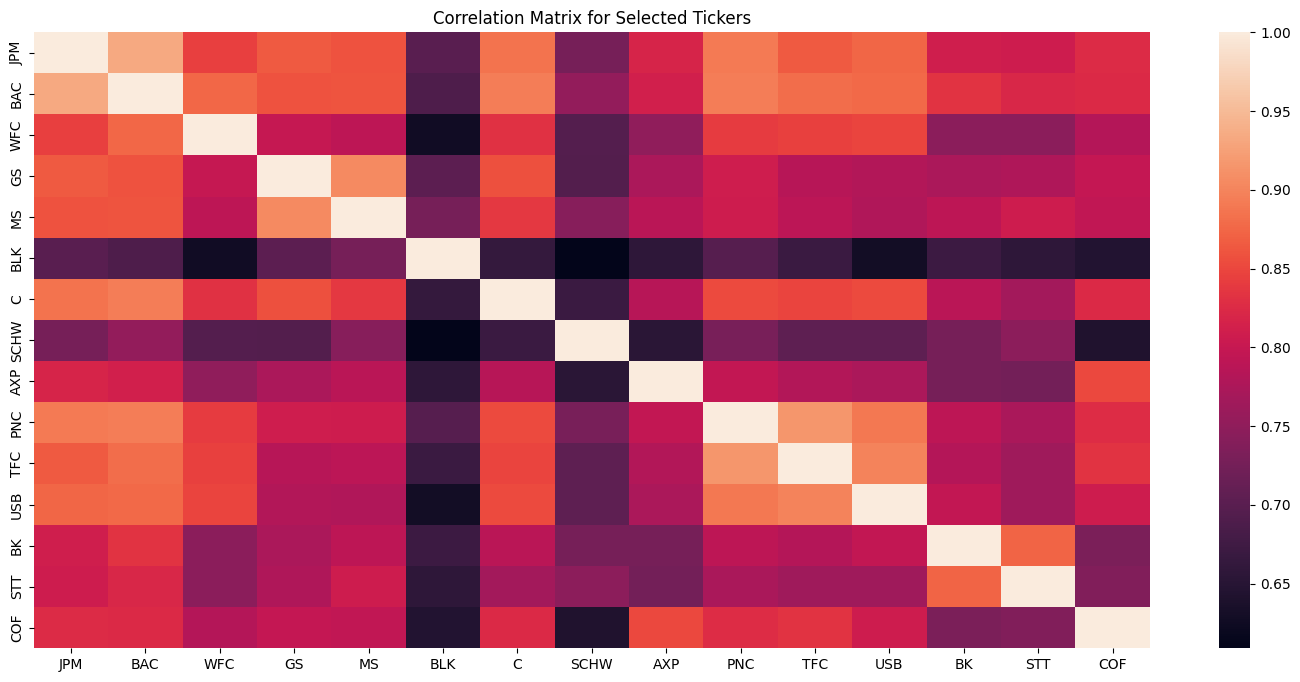

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix)
plt.title("Correlation Matrix for Selected Tickers")


In [16]:
print(stocks[0])
technical_dfs[stocks[0]]

BLK


Price,Adj Close,Close,High,Low,Open,Volume,SMA_20,SMA_5,RSI,MACD,Signal_Line,BB_middle,BB_upper,BB_lower,Volume_ROC
Date,,,,,,,,,,,,,,,
2019-07-01 00:00:00+00:00,413.319397,472.929993,477.140015,468.959991,474.880005,471100,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
2019-07-02 00:00:00+00:00,410.645111,469.869995,473.100006,467.670013,472.970001,347000,NaN,NaN,NaN,-0.213333,-0.042667,NaN,NaN,NaN,NaN
2019-07-03 00:00:00+00:00,415.434387,475.350006,477.079987,471.200012,471.359985,343900,NaN,NaN,NaN,0.004007,-0.033332,NaN,NaN,NaN,NaN
2019-07-05 00:00:00+00:00,418.353333,478.690002,478.760010,472.209991,475.299988,383100,NaN,NaN,NaN,0.407092,0.054753,NaN,NaN,NaN,NaN
2019-07-08 00:00:00+00:00,412.891205,472.440002,477.209991,471.950012,474.059998,414600,NaN,414.128687,NaN,0.282535,0.100309,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,671.564392,703.940002,710.099976,700.200012,708.770020,363200,674.819257,668.614587,47.994709,3.201403,6.214414,674.819257,689.918337,659.720177,-78.598786
2022-12-27 00:00:00+00:00,670.915649,703.260010,707.599976,700.500000,704.570007,325100,674.200470,670.673340,46.357936,2.852223,5.541976,674.200470,688.845166,659.555774,-46.415032
2022-12-28 00:00:00+00:00,668.120422,700.330017,711.809998,700.289978,704.000000,457700,673.781589,672.346680,45.509116,2.323165,4.898214,673.781589,688.627447,658.935730,-22.436875


In [17]:
print(stocks[1])
technical_dfs[stocks[1]]

SCHW


Price,Adj Close,Close,High,Low,Open,Volume,SMA_20,SMA_5,RSI,MACD,Signal_Line,BB_middle,BB_upper,BB_lower,Volume_ROC
Date,,,,,,,,,,,,,,,
2019-07-01 00:00:00+00:00,37.765163,40.759998,41.180000,40.419998,40.880001,21507800,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
2019-07-02 00:00:00+00:00,37.237053,40.189999,40.740002,40.130001,40.459999,6426900,NaN,NaN,NaN,-0.042128,-0.008426,NaN,NaN,NaN,NaN
2019-07-03 00:00:00+00:00,37.477947,40.450001,40.590000,40.150002,40.410000,3019500,NaN,NaN,NaN,-0.055438,-0.017828,NaN,NaN,NaN,NaN
2019-07-05 00:00:00+00:00,37.857811,40.860001,41.480000,40.730000,40.820000,6522300,NaN,NaN,NaN,-0.034932,-0.021249,NaN,NaN,NaN,NaN
2019-07-08 00:00:00+00:00,37.051735,39.990002,40.830002,39.910000,40.380001,7209400,NaN,37.477942,NaN,-0.082770,-0.033553,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23 00:00:00+00:00,79.507545,81.769997,82.150002,80.260002,80.779999,4756400,77.849239,78.105449,52.442409,0.468337,0.411355,77.849239,81.016993,74.681486,-65.676844
2022-12-27 00:00:00+00:00,79.945099,82.220001,82.769997,81.709999,82.110001,5346500,77.965432,78.875534,57.652709,0.611164,0.451316,77.965432,81.265680,74.665184,-17.469359
2022-12-28 00:00:00+00:00,80.071495,82.349998,82.989998,81.940002,82.370003,3382700,78.060720,79.418092,60.404603,0.726183,0.506290,78.060720,81.492739,74.628702,-52.428031


In [18]:
yf.Ticker("BLK").quarterly_financials

,2024-06-30,2024-03-31,2023-12-31,2023-09-30,2023-06-30
Tax Effect Of Unusual Items,38478000.0,27456000.0,46823040.996367,13689000.0,55860000.0
Tax Rate For Calcs,0.242,0.156,0.227296,0.117,0.245
Normalized EBITDA,2089000000.0,1940000000.0,1914000000.0,1881000000.0,1809000000.0
Total Unusual Items,159000000.0,176000000.0,206000000.0,117000000.0,228000000.0
Total Unusual Items Excluding Goodwill,159000000.0,176000000.0,206000000.0,117000000.0,228000000.0
Net Income From Continuing Operation Net Minority Interest,1495000000.0,1573000000.0,1375000000.0,1604000000.0,1366000000.0
Reconciled Depreciation,108000000.0,111000000.0,111000000.0,108000000.0,102000000.0
Reconciled Cost Of Revenue,2426000000.0,2461000000.0,2340000000.0,2316000000.0,2322000000.0
EBITDA,2248000000.0,2116000000.0,2120000000.0,1998000000.0,2037000000.0
EBIT,2140000000.0,2005000000.0,2009000000.0,1890000000.0,1935000000.0


In [19]:
sp500

Ticker,^GSPC
Date,
2019-07-01 00:00:00+00:00,2964.330078
2019-07-02 00:00:00+00:00,2973.010010
2019-07-03 00:00:00+00:00,2995.820068
2019-07-05 00:00:00+00:00,2990.409912
2019-07-08 00:00:00+00:00,2975.949951
...,...
2022-12-23 00:00:00+00:00,3844.820068
2022-12-27 00:00:00+00:00,3829.250000
2022-12-28 00:00:00+00:00,3783.219971


In [20]:
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

fig = make_subplots(2, 1)
fig.add_trace(go.Scatter(x=sp500.index, y=sp500["^GSPC"].values, name="S&P 500"), row=1, col=1)
fig.add_trace(go.Scatter(x=vix.index, y=vix["^VIX"].values, name="VIX"), row=2, col=1)
fig.update_layout(height=600, width=1500, title_text="S&P 500 and VIX")
fig.show()

# vix.plot()
# for i in vix.nlargest(10, columns="^VIX").iterrows():
#   plt.axvline(i[0])
# plt.grid(True)
# plt.figure(figsize=(18, 4))


In [21]:
sp500["^GSPC"]

,^GSPC
Date,
2019-07-01 00:00:00+00:00,2964.330078
2019-07-02 00:00:00+00:00,2973.010010
2019-07-03 00:00:00+00:00,2995.820068
2019-07-05 00:00:00+00:00,2990.409912
2019-07-08 00:00:00+00:00,2975.949951
...,...
2022-12-23 00:00:00+00:00,3844.820068
2022-12-27 00:00:00+00:00,3829.250000
2022-12-28 00:00:00+00:00,3783.219971


In [22]:
def get_sharpe_ratio(name, temp_stock, time):
  """
  name: stock_name,
  stock: stock_data,
  indicator: indicator_name,
  n: number of days
  return the sharpe ratio of the stock on given time period
  """
  three_month_treasury = yf.Ticker("^IRX")
  data = three_month_treasury.history(start=time[0], end=time[1])
  data["Adj Close"] = data["Close"] / 100 + 1
  data["Cumulative Return"] = data["Adj Close"].cumprod()
  risk_free_3_month_nominal = (data.loc[data.index[-1], "Cumulative Return"]) ** (1 / data.shape[0]) - 1
  R_f_EAR = (1 + risk_free_3_month_nominal / 4) ** 4 - 1
  PV, FV = temp_stock.loc[temp_stock.index[0], "Adj Close"], temp_stock.loc[temp_stock.index[-1], "Adj Close"]
  R = (FV - PV) / PV
  sharp_ratio = (R - R_f_EAR) / temp_stock["Adj Close"].std()
  return sharp_ratio
for i in range(2):
  print(f"{stocks[i]}'s Sharpe Ratio: {get_sharpe_ratio(stocks[i], technical_dfs[stocks[i]], ('2019-07-01', '2023-01-31')):.3}")


BLK's Sharpe Ratio: 0.00416
SCHW's Sharpe Ratio: 0.0633


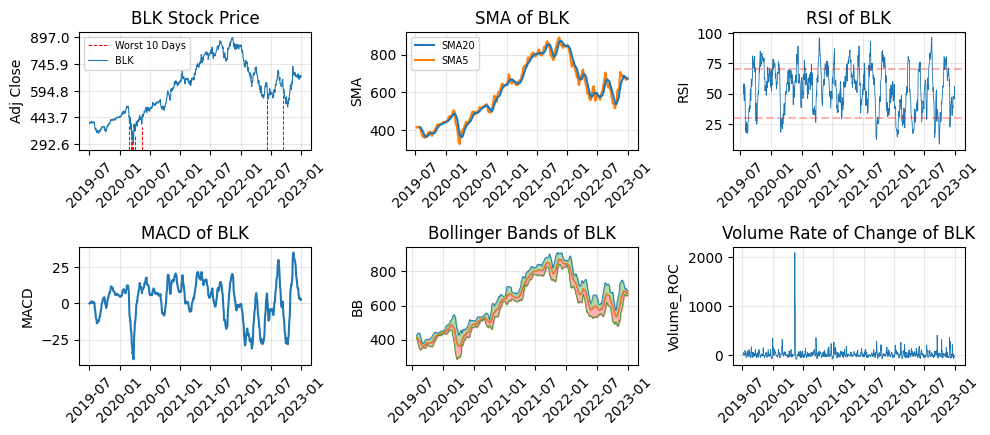

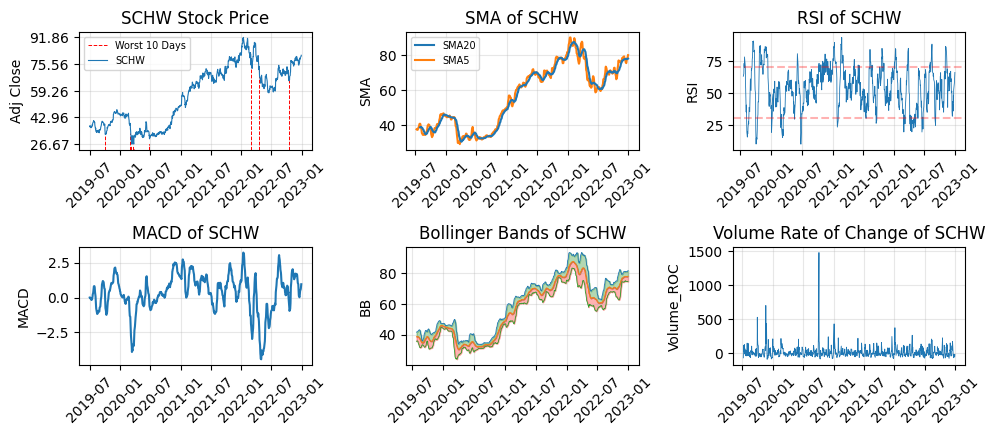

In [23]:

def get_six_plots(name, data, best=False):
  """
  name: stock_name,
  stock: stock_data,
  indicator: indicator_name,
  n: number of days
  best: if True, plot the best days, else plot the worst days

  plot the underlying adj close price
  plot the underlying indicator information
  """
  plt.figure(figsize=(10, 6))
  plt.subplot(331)
  n = 10
  data["pct"] = data["Adj Close"].pct_change() #rolling(window=n).mean()
  worst_days = data.nsmallest(n, "pct")
  best_days = data.nlargest(n, "pct")
  MIN, MAX = data["Adj Close"].min(), data["Adj Close"].max()
  if best:
    for idx, row in best_days.iterrows():
        plt.axvline(x=idx, color='green', ymax=(row["Adj Close"] - MIN) / (MAX - MIN), linestyle='--', linewidth=0.7)
    plt.axvline(x=best_days.index[-1], color='green', ymax=(best_days.loc[best_days.index[-1], "Adj Close"] - MIN) / (MAX - MIN), linestyle='--', label=f"Best {n} Days", linewidth=0.7)
  else:
    for idx, row in worst_days.iterrows():
      plt.axvline(x=idx, color='red', ymax=(row["Adj Close"] - MIN) / (MAX - MIN), linestyle='--', linewidth=0.7)
    plt.axvline(x=worst_days.index[-1], color='red', ymax=(worst_days.loc[worst_days.index[-1], "Adj Close"] - MIN) / (MAX - MIN), linestyle='--', label=f"Worst {n} Days", linewidth=0.7)
  plt.plot(data.index, data['Adj Close'], label=name, linewidth=0.8)
  plt.title(f"{name} Stock Price")
  plt.ylabel("Adj Close")
  plt.yticks(np.linspace(data["Adj Close"].min(), data["Adj Close"].max(), 5))
  plt.xticks(rotation=45)
  plt.grid(alpha=0.3)
  plt.legend(fontsize=7)

  plt.subplot(332)
  plt.plot(data.index, data["SMA_20"], label="SMA20", zorder=5)
  plt.plot(data.index, data["SMA_5"], label="SMA5")
  plt.title(f"SMA of {name}")
  plt.ylabel("SMA")
  plt.xticks(rotation=45)
  plt.grid(alpha=0.3)
  plt.legend(fontsize=7)


  plt.subplot(333)
  plt.plot(data.index, data["RSI"], linewidth=0.6)
  plt.title(f"RSI of {name}")
  plt.ylabel("RSI")
  plt.xticks(rotation=45)
  plt.grid(alpha=0.3)
  plt.axhline(y=30, color='r', linestyle='--', alpha=0.3)
  plt.axhline(y=70, color='r', linestyle='--', alpha=0.3)


  plt.subplot(334)
  plt.plot(data.index, data["MACD"], label="MACD")
  plt.title(f"MACD of {name}")
  plt.ylabel("MACD")
  plt.xticks(rotation=45)
  plt.grid(alpha=0.3)


  plt.subplot(335)
  plt.plot(data.index, data["BB_upper"], linewidth=0.6)
  plt.plot(data.index, data["BB_middle"], linewidth=0.6)
  plt.plot(data.index, data["BB_lower"], linewidth=0.6)
  # plt.plot(data.index, data["Adj Close"], linewidth=0.2, c="black")
  plt.xticks(rotation=45)
  plt.ylabel("BB")
  plt.title(f"Bollinger Bands of {name}")
  plt.fill_between(data.index, data["BB_upper"], data["BB_middle"], alpha=0.3, color='green')
  plt.fill_between(data.index, data["BB_middle"], data["BB_lower"], alpha=0.3, color='red')
  plt.grid(alpha=0.3)
  plt.tight_layout()

  plt.subplot(336)
  plt.plot(data.index, data["Volume_ROC"], linewidth=0.6)
  plt.title(f"Volume Rate of Change of {name}")
  plt.xticks(rotation=45)
  plt.ylabel("Volume_ROC")
  plt.grid(alpha=0.3)

  plt.tight_layout()
  plt.show()
for i in range(2):
  get_six_plots(stocks[i], technical_dfs[stocks[i]])
